In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


## 加载数据

In [36]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_ds = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分
# 从数据集到dataloader
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_ds, batch_size=16, shuffle=False)

In [37]:
from torchvision.transforms import Normalize

# 遍历train_ds得到每张图片，计算每个通道的均值和方差
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds: # 遍历每张图片,img.shape=[1,28,28]
        mean += img.mean(dim=(1, 2))
        std += img.std(dim=(1, 2))
    mean /= len(ds)
    std /= len(ds)
    return mean, std


print(cal_mean_std(train_ds))
# 0.2860， 0.3205
transforms = nn.Sequential(
    Normalize([0.2860], [0.3205]) # 这里的均值和标准差是通过train_ds计算得到的
)


(tensor([0.2860]), tensor([0.3205]))


## 定义模型

这里我们没有用`nn.Linear`的默认初始化，而是采用了xavier均匀分布去初始化全连接层的权重

xavier初始化出自论文 《Understanding the difficulty of training deep feedforward neural networks》，适用于使用`tanh`和`sigmoid`激活函数的方法。当然，我们这里的模型采用的是`relu`激活函数，采用He初始化（何凯明初始化）会更加合适。感兴趣的同学可以自己动手修改并比对效果。

|神经网络层数|初始化方式|early stop at epoch| val_loss | vla_acc|
|-|-|-|-|-|
|20|默认|
|20|xaviier_uniform|
|20|he_uniform|
|...|

He初始化出自论文 《Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification》

In [38]:
class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=2):
        super().__init__()
        self.transforms = transforms # 预处理层，标准化
        self.flatten = nn.Flatten()
        # 多加几层
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 100),
            nn.ReLU(),
        )
        # 加19层
        for i in range(1, layers_num):
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(100, 100))
            self.linear_relu_stack.add_module(f"relu", nn.ReLU())
        # 输出层
        self.linear_relu_stack.add_module("Output Layer", nn.Linear(100, 10))
        
        # 初始化权重
        self.init_weights()
        
    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        # print('''初始化权重''')
        for m in self.modules():
            # print(m)
            # print('-'*50)
            if isinstance(m, nn.Linear):#判断m是否为全连接层
                # https://pytorch.org/docs/stable/nn.init.html
                nn.init.xavier_uniform_(m.weight) # xavier 均匀分布初始化权重
                nn.init.zeros_(m.bias) # 全零初始化偏置项
        # print('''初始化权重完成''')
    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.transforms(x) #标准化
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits
total=0
for idx, (key, value) in enumerate(NeuralNetwork(20).named_parameters()):
    # print(f"Linear_{idx // 2:>02}\tparamerters num: {np.prod(value.shape)}") #np.prod是计算张量的元素个数
    # print(f"Linear_{idx // 2:>02}\tshape: {value.shape}")
    total+=np.prod(value.shape)
total #模型参数数量

271410

In [39]:
w = torch.empty(3, 5)
print(w)
nn.init.eye_(w)

tensor([[-1.7012e+12,  1.0103e-42,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  1.4013e-45,  0.0000e+00,  0.0000e+00]])


tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

## 训练

In [40]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    pred_list = []
    label_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
        preds = logits.argmax(axis=-1)    # 验证集预测
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())
        
    acc = accuracy_score(label_list, pred_list)
    return np.mean(loss_list), acc


In [41]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


In [42]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [43]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [44]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                    
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 100

model = NeuralNetwork(layers_num=10)


In [45]:
# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 1. tensorboard 可视化
tensorboard_callback = TensorBoardCallback("runs")
tensorboard_callback.draw_model(model, [1, 28, 28])
# 2. save best
save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=0.001)

model = model.to(device)

In [46]:
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

  0%|          | 0/375000 [00:00<?, ?it/s]

Early stop at epoch 29 / global_step 108750


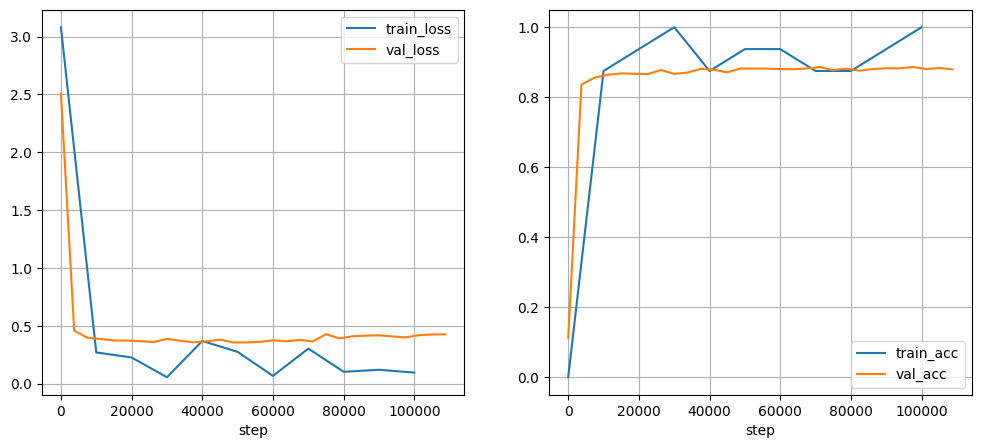

In [47]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(6 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=10000)  #横坐标是 steps

In [48]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/best.ckpt", weights_only=True,map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.4257
accuracy: 0.8834
